# Exercício 5.1

Utilizando o exemplo visto com o SVM e o dataset Titanic faça um GridSearch para encontrar a melhor configuração de parâmetros, entre o tipo de Kernel, pré-processamento (StandardScalar e MinMaxScalar), Gamma e C.  

Qual foi a melhor configuração que você encontrou? Qual a melhor acurácia?  

Dica:
 - Observe a matriz de confusão para verificar se o classificar está conseguindo classificar dados das duas classes;  
 - Normalize os dados;  

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
# A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas. 
# Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:xlabel='Survived', ylabel='count'>

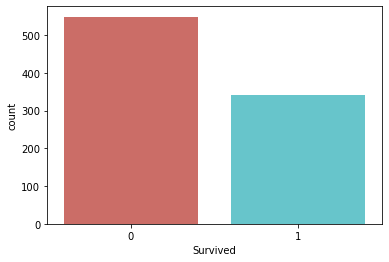

In [3]:
# VARIABLE DESCRIPTIONS
# Survived - Survival (0 = No; 1 = Yes);
# Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);
# Name - Name;
# Sex - Sex;
# Age - Age;
# SibSp - Number of Siblings/Spouses Aboard;
# Parch - Number of Parents/Children Aboard;
# Ticket - Ticket Number;
# Fare - Passenger Fare (British pound);
# Cabin - Cabin;
# Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);

# Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
# Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.


sb.countplot(x='Survived',data=titanic, palette='hls')


In [4]:
# Ok, agora veja que a variavel Survived é binária

# # Checking for missing values
# É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variaveis

titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa variável completamente! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

# # Lidando com missing values
# Removendo missing values
# Vamos além dos missing values... Vamos descartar todas as variáveis que não são relevantes para a predição de Survived.


#E quanto ao nome de uma pessoa, número do bilhete e número de identificação do passageiro? Eles são irrelavantes para prever a capacidade de sobrevivência. E, como você se lembra, a variável cabine é quase todoa com missing values!!
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

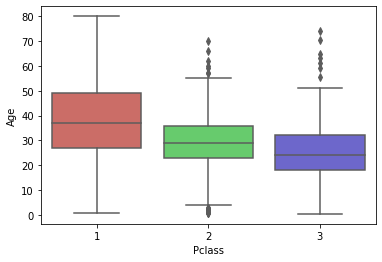

In [7]:
# Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

# # Imputing missing values
# Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.


sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [8]:
# Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.
# 
# Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.


def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age


# Após definir a função, vamos executar apenas para os valores nulos de Age

titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [9]:
# Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [10]:
# Converting categorical variables to a dummy indicators
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()


#Ainda não alteramos os dados! Vamos alterar em seguida.
titanic_data.head()

titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.head()

titanic_dmy.drop(['Q'],axis=1,inplace=True)
titanic_dmy.head()

# X = titanic_dmy.iloc[:,[1,2,3,4,5,6]].values
y = titanic_dmy.iloc[:,0].values

In [11]:

#Normalização do Conjunto utilizando MinMaxScalar
X = MinMaxScaler().fit_transform(titanic_dmy.iloc[:,[1,2,3,4,5,6]].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [12]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1000,100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'sigmoid', 'linear']}


grid_search = GridSearchCV(SVC(), param_grid,verbose = 3, cv=5, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)  

#Imprime os Melhores parâmetros Encontrados
print(grid_search.best_params_)

#Imprime os Melhores parâmetros Encontrados
print(grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 738 tasks      | elapsed:    5.1s


{'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.8215483870967744


[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   16.5s finished


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       164
           1       0.78      0.71      0.74       103

    accuracy                           0.81       267
   macro avg       0.81      0.79      0.80       267
weighted avg       0.81      0.81      0.81       267

0.8127340823970037
[[144  20]
 [ 30  73]]


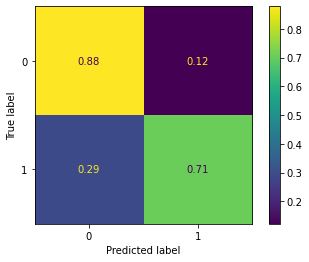

In [13]:
bestSVM = grid_search.best_estimator_

y_pred = bestSVM.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(bestSVM, X_test, y_test, normalize = 'true');

In [14]:
#Normalização do Conjunto utilizando StandardScaler
X = StandardScaler().fit_transform(titanic_dmy.iloc[:,[1,2,3,4,5,6]].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [15]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1000,100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'sigmoid', 'linear']}


grid_search = GridSearchCV(SVC(), param_grid,verbose = 3, cv=5, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)  

#Imprime os Melhores parâmetros Encontrados
print(grid_search.best_params_)

#Imprime os Melhores parâmetros Encontrados
print(grid_search.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 769 tasks      | elapsed:  1.0min


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.8263612903225808


[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  4.0min finished


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       164
           1       0.79      0.72      0.75       103

    accuracy                           0.82       267
   macro avg       0.81      0.80      0.80       267
weighted avg       0.81      0.82      0.81       267

0.8164794007490637
[[144  20]
 [ 29  74]]


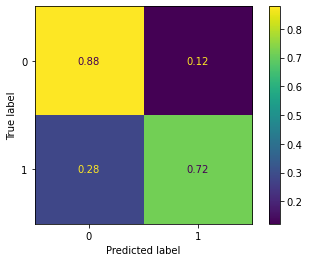

In [16]:
bestSVM = grid_search.best_estimator_

y_pred = bestSVM.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(bestSVM, X_test, y_test, normalize = 'true');

# Qual foi a melhor configuração que você encontrou? Qual a melhor acurácia? 
A melhor combinação encontrada foi feita com o pré-processamento 'StandardScaler', kernel 'rbf', gamma 0.1 e C 1.  
Para a combinação citada o valor de acurácia encontrado foi de 0.8164, errando 29 dos preditos como classe 0 e 20 dos preditos como classe 1 dentre um total de 267 amostras no conjunto de teste.